In [1]:
root_dir = "../../Downloads/GENOME540/"
read_count_path = root_dir + "chm13.chr16.txt"

In [2]:
import numpy as np

def read_rc(filename):
    return np.loadtxt(filename, usecols=(2,))

true_read_count = read_rc(read_count_path)

In [3]:
from scipy.stats import poisson

N_CORRECTION = 8422401 # number of Ns in chr16

def create_scoring_scheme_poisson(read_counts):

    adj_chrom_size = read_counts.shape[0] - N_CORRECTION
    adj_mean_count = np.sum(read_counts) / adj_chrom_size

    mu_0 = adj_mean_count
    mu_1 = adj_mean_count * 1.5

    x = np.arange(4)
    y_0 = poisson.pmf(mu=mu_0, k=x)
    y_1 = poisson.pmf(mu=mu_1, k=x)

    y_0[-1] += 1.0 - np.sum(y_0)
    y_1[-1] += 1.0 - np.sum(y_1)

    weights = np.log2(y_1 / y_0)

    return dict(zip([0,1,2,3,4], weights))

score_scheme = create_scoring_scheme_poisson(true_read_count)
D, S = -20.0, 20.0

In [4]:
true_read_count = np.array([min(x, 3) for x in true_read_count], dtype="int16")

def find_dsegs(read_counts, scoring_scheme, d, s):

    scorez = [scoring_scheme[n] for n in read_counts]

    cumulative = maximum = start = 0
    for i in range(len(scorez)):
        cumulative += scorez[i]
        if cumulative >= maximum:
            maximum = cumulative
            end = i
        if cumulative <= 0 or cumulative <= maximum + d or i == len(scorez)-1:
            if maximum >= s:
                yield start, end, maximum
            cumulative = maximum = 0
            start = end = i + 1

elevated = list(find_dsegs(true_read_count, score_scheme, D, S))

In [5]:
def calc_y_0(read_counts):

    chrom_size = read_counts.shape[0]
    adj_chrom_size = chrom_size - N_CORRECTION

    _, counts = np.unique(np.sort(read_counts)[N_CORRECTION:], return_counts=True)
    return counts / adj_chrom_size

back_freq = calc_y_0(true_read_count)

In [6]:
def calc_y_1(read_counts, elev):

    elev_size = 0
    y_1 = np.arange(4)
    for elevated_seq in elev:
        elev_seq = read_counts[elevated_seq[0]: elevated_seq[1]+1]
        y_1 += np.bincount(elev_seq, minlength=4)
        elev_size += elev_seq.shape[0]

    return y_1 / elev_size

elev_freq = calc_y_1(true_read_count, elevated)

In [7]:
def create_scoring_scheme(y_0, y_1):

    weights = np.log2(y_1 / y_0)
    scoring_scheme = dict(zip([0,1,2,3], weights))

    return scoring_scheme

new_score_scheme = create_scoring_scheme(back_freq, elev_freq)
new_score_scheme

{0: -0.2158228606244275,
 1: 0.7403389453175171,
 2: 1.7446876421214268,
 3: 4.649160625579168}

In [8]:
print("Background frequencies:")
print(f"0={back_freq[0]:.4f}")
print(f"1={back_freq[1]:.4f}")
print(f"2={back_freq[2]:.4f}")
print(f">=3={back_freq[3]:.4f}")

print("\nTarget frequencies:")
print(f"0={elev_freq[0]:.4f}")
print(f"1={elev_freq[1]:.4f}")
print(f"2={elev_freq[2]:.4f}")
print(f">=3={elev_freq[3]:.4f}")

print("\nScoring scheme:")
print(f"0={new_score_scheme[0]:.4f}")
print(f"1={new_score_scheme[1]:.4f}")
print(f"2={new_score_scheme[2]:.4f}")
print(f">=3={new_score_scheme[3]:.4f}")

Background frequencies:
0=0.8773
1=0.1126
2=0.0090
>=3=0.0010

Target frequencies:
0=0.7554
1=0.1882
2=0.0301
>=3=0.0263

Scoring scheme:
0=-0.2158
1=0.7403
2=1.7447
>=3=4.6492


In [9]:
sim_read_count = np.digitize(np.random.random(size=len(true_read_count) - N_CORRECTION), np.cumsum(back_freq))

In [10]:
D, S = -5.0, 5.0
true_dsegs = list(find_dsegs(true_read_count, new_score_scheme, D, S))
sim_dsegs = list(find_dsegs(sim_read_count, new_score_scheme, D, S))

In [11]:
def count_by_score(arr, score):
    return sum(1 for _, _, s in arr if s >= score)

def display_dseg_stats(dsegs1, dsegs2):

    print("Real data:")
    for s in range(5, 31):
        print(s, count_by_score(dsegs1, s))

    print("\nSimulated data:")
    for s in range(5, 31):
        print(s, count_by_score(dsegs2, s))

    print("\nRatios of simulated data:")
    for s in range(5, 30):
        denom = count_by_score(dsegs2, s+1)
        if denom == 0:
            ratio = -1
        else:
            ratio = count_by_score(dsegs2, s) / denom

        print(f"N_seg({s})/N_seg({s+1}) {ratio:.2f}")

display_dseg_stats(true_dsegs, sim_dsegs)

Real data:
5 71547
6 39373
7 22504
8 13939
9 9250
10 6568
11 4945
12 3966
13 3335
14 2860
15 2512
16 2237
17 2068
18 1897
19 1754
20 1625
21 1536
22 1459
23 1374
24 1309
25 1237
26 1176
27 1126
28 1081
29 1025
30 983

Simulated data:
5 79982
6 39204
7 18530
8 9117
9 4618
10 2342
11 1125
12 559
13 291
14 156
15 75
16 34
17 17
18 9
19 2
20 2
21 1
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0

Ratios of simulated data:
N_seg(5)/N_seg(6) 2.04
N_seg(6)/N_seg(7) 2.12
N_seg(7)/N_seg(8) 2.03
N_seg(8)/N_seg(9) 1.97
N_seg(9)/N_seg(10) 1.97
N_seg(10)/N_seg(11) 2.08
N_seg(11)/N_seg(12) 2.01
N_seg(12)/N_seg(13) 1.92
N_seg(13)/N_seg(14) 1.87
N_seg(14)/N_seg(15) 2.08
N_seg(15)/N_seg(16) 2.21
N_seg(16)/N_seg(17) 2.00
N_seg(17)/N_seg(18) 1.89
N_seg(18)/N_seg(19) 4.50
N_seg(19)/N_seg(20) 1.00
N_seg(20)/N_seg(21) 2.00
N_seg(21)/N_seg(22) -1.00
N_seg(22)/N_seg(23) -1.00
N_seg(23)/N_seg(24) -1.00
N_seg(24)/N_seg(25) -1.00
N_seg(25)/N_seg(26) -1.00
N_seg(26)/N_seg(27) -1.00
N_seg(27)/N_seg(28) -1.00
N_seg(28

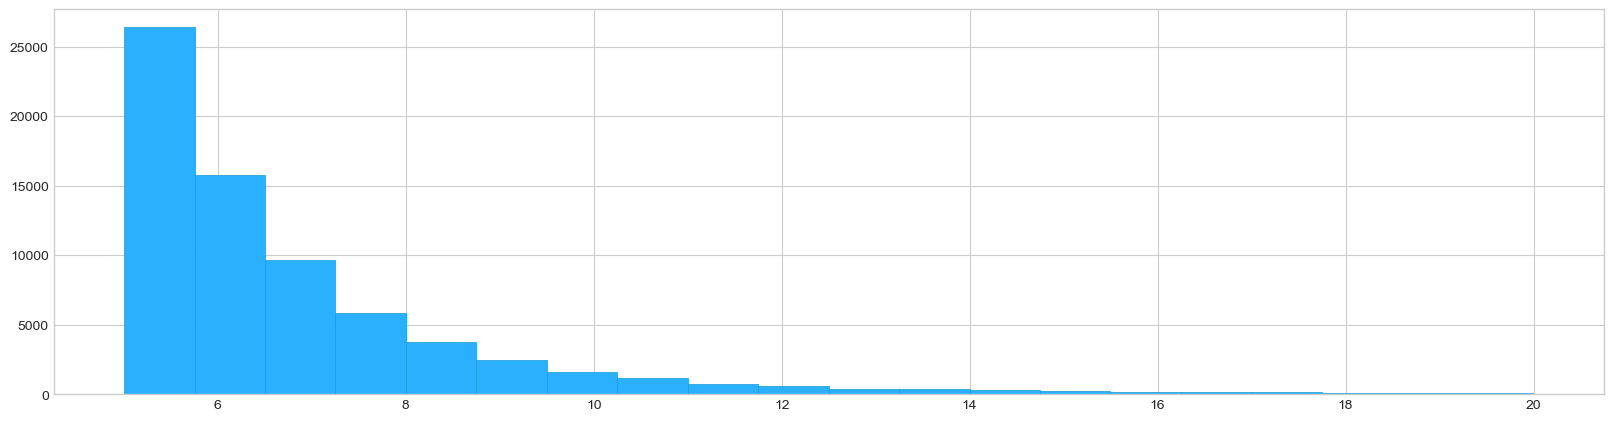

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 5))
plt.style.use('seaborn-v0_8-whitegrid')
plt.hist([x[-1] for x in true_dsegs if x[-1]<=20], bins=20, facecolor='#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.show()

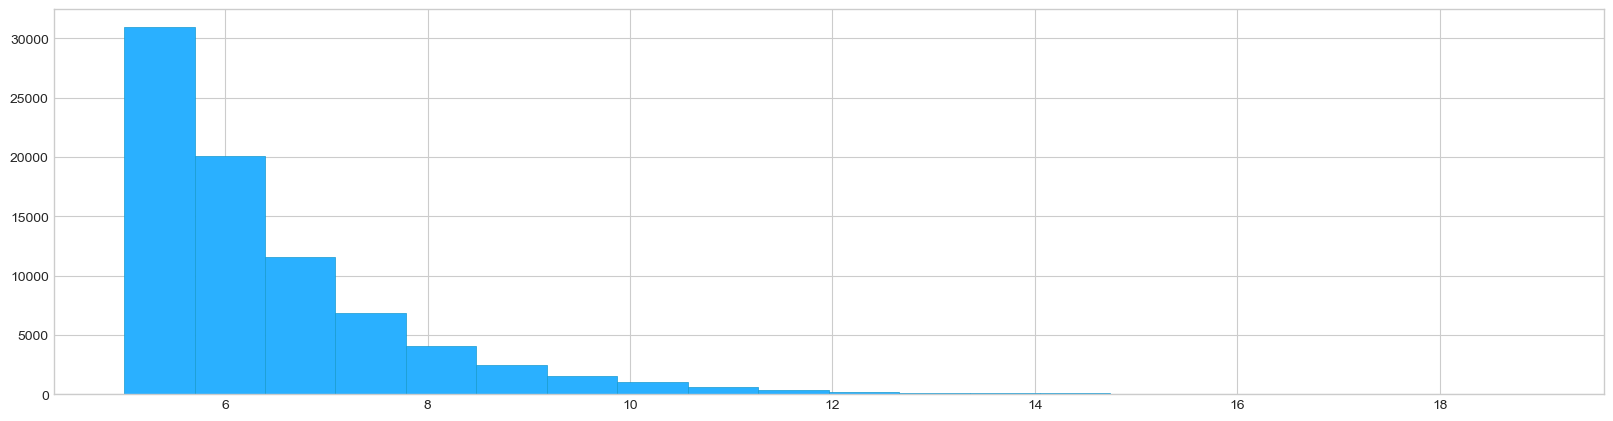

In [13]:
plt.figure(figsize=(20, 5))
plt.style.use('seaborn-v0_8-whitegrid')
plt.hist([x[-1] for x in sim_dsegs if x[-1]<=20], bins=20, facecolor='#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.show()